In [1]:
from libPytorch.model_NST import *
from IPython.display import clear_output

from pylab import *
%matplotlib inline
plt.rc("figure",facecolor="w",figsize=(6,4))

In [2]:
# Image preprocessing
imH,imW = 250,280
# For normalization, see https://github.com/pytorch/vision#models
denorm    = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
transform = transforms.Compose([transforms.Resize((imH,imW)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), 
                                                     (0.229, 0.224, 0.225))
                               ])

content   = Variable(image_loader('../data/images/me.jpg', transform ))
style     = Variable(image_loader('../data/images/s2.jpg', transform ))
parameter = Variable(content.data.clone(), requires_grad=True)

vgg     = VGGNet().cuda()

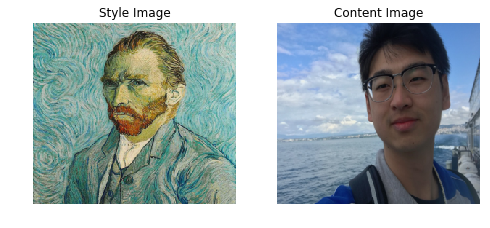

In [3]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
tensor_shower(style.data,imH,imW,title = 'Style Image',denorm = denorm )

plt.subplot(1,2,2)
tensor_shower(content.data,imH,imW,title = 'Content Image',denorm = denorm )

In [5]:
optimizer = torch.optim.LBFGS([parameter])
STYLE_WEIGHT  = 1000.0

In [6]:
def closure():
    optimizer.zero_grad()
    
    # correct the values of updated input image
    f_parameter = vgg(parameter)
    f_content   = vgg(content)
    f_style     = vgg(style)
    
    loss_style   = 0
    loss_content = 0
    
    for l, fp in enumerate(f_parameter):
        fc = f_content[l]
        fs = f_style[l]
            
        # Compute content loss (target and content image)
        if l == 1:
            loss_content += torch.mean((fp - fc)**2)

        # Reshape conv features
        _, c, h, w = fp.size()
        fp = fp.view(c, h * w)
        fs = fs.view(c, h * w)
        # Compute gram matrix  
        gram_p = torch.mm(fp, fp.t())
        gram_s = torch.mm(fs, fs.t())
        # Compute style loss (target and style image)
        loss_style += torch.mean((gram_p - gram_s)**2) / (c * h * w) 
        
    loss = loss_content + loss_style * STYLE_WEIGHT
    loss.backward()
    
    print('content loss {:6.4f}, style loss {:6.4f}'.format(loss_content.data[0], loss_style.data[0] * STYLE_WEIGHT))
    clear_output(wait=True)
    return loss

In [7]:
for i in range(40):
    optimizer.step(closure)
    img    = denorm(parameter.clone().cpu().squeeze().data).clamp_(0, 1)
    torchvision.utils.save_image(img, '../plot/nst/outputs{}.png'.format(i))

content loss 2.5509, style loss 293.6277


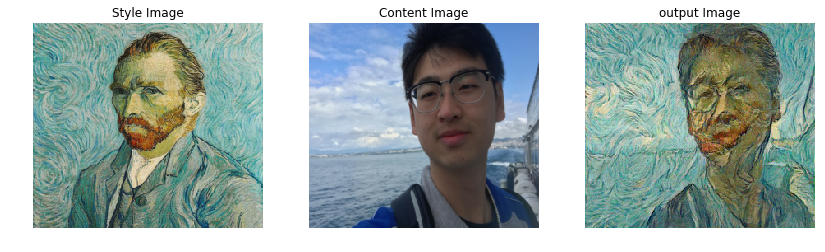

In [8]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
tensor_shower(style.data,imH,imW,title = 'Style Image',denorm = denorm)

plt.subplot(1,3,2)
tensor_shower(content.data,imH,imW,title = 'Content Image',denorm = denorm)

plt.subplot(1,3,3)
img = denorm(parameter.clone().cpu().squeeze().data).clamp_(0, 1)
tensor_shower(img,imH,imW,title = 'output Image')

In [10]:
img = denorm(content.clone().cpu().squeeze().data).clamp_(0, 1)
torchvision.utils.save_image(img, '../plot/nst/outputs.png')